In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt


from Labels import id_to_color
from DataGenerator import DataGenerator
from CBAM_Unet import CBAMUnet
from SE_Unet import SEUnet

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [29]:
def get_image_path_list(path, endswith):
    image_path_list = []
    for folder in os.listdir(path):
        image_path_list.extend([ os.path.join(os.path.join(path,folder), filename) for filename in os.listdir( os.path.join(path, folder) ) if filename.split("_")[-1] == endswith ])
    return image_path_list

def plot_image( img, gray = False ):
    plt.figure( figsize = ( 3,3 ) )
    if gray:
        plt.imshow( img, cmap="gray") 
    else:
        plt.imshow( img )           
    plt.show()

train_input_image_paths = sorted(get_image_path_list("Cityscapes/train", "leftImg8bit.png"))
train_segmented_image_paths = sorted(get_image_path_list("Cityscapes/train", "color.png"))

val_input_image_paths = sorted(get_image_path_list("Cityscapes/val", "leftImg8bit.png"))
val_segmented_image_paths = sorted(get_image_path_list("Cityscapes/val", "color.png"))

train_gen = DataGenerator(train_input_image_paths, train_segmented_image_paths, batch_size=8, id_to_color= id_to_color)

test_gen = DataGenerator(val_input_image_paths, val_segmented_image_paths, batch_size=8, id_to_color=id_to_color)

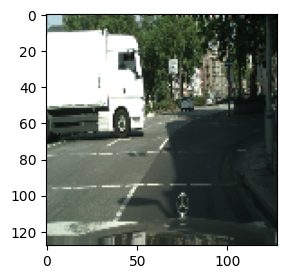

In [30]:
batch =  test_gen.__getitem__(2)
inp, out = batch
plot_image(inp[0])

In [4]:
from keras import backend as K
@tf.keras.saving.register_keras_serializable()
def dice_coef(y_true, y_pred):
  y_pred = tf.nn.softmax(y_pred)
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + 0.01) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.01)

@tf.keras.saving.register_keras_serializable()
def dice_coef_multilabel(y_true, y_pred, numLabels=35):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice
     

Note: My kernel used to crash everytime after one training cell finished and the other one started. So, I trained the models seperately and am showing the outputs here.

In [5]:
# SE_unet = SEUnet()

# SE_unet.compile(
#     optimizer=tf.keras.optimizers.AdamW(weight_decay = 0.0005, learning_rate = 0.001),
#     loss= tf.keras.losses.CategoricalFocalCrossentropy(label_smoothing = 0.1, from_logits = True),
#     metrics=['accuracy', dice_coef_multilabel]
# )

In [6]:
# cbam_unet = CBAMUnet()

# cbam_unet.compile(
#     optimizer=tf.keras.optimizers.AdamW(weight_decay = 0.0005, learning_rate = 0.001),
#     loss= tf.keras.losses.CategoricalFocalCrossentropy(label_smoothing = 0.1, from_logits = True),
#     metrics=['accuracy', dice_coef_multilabel]
# )

In [7]:
# SE_history = SE_unet.fit(
#     train_gen,
#     epochs=10,
#     validation_data=test_gen
# )

In [8]:
# SE_unet.save('SE_unet.keras')

In [9]:
# CBAM_history = cbam_unet.fit(
#     train_gen,
#     epochs=10,
#     validation_data=test_gen
# )

In [10]:
# def plot_history(history,item,path):
#     plt.plot(history.history[item], label=item)
#     plt.plot(history.history["val_" + item], label="val_" + item)
#     plt.xlabel("Epochs")
#     plt.ylabel(item)
#     plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
#     plt.legend()
#     plt.grid()
#     plt.savefig(path)
#     plt.show()


# plot_history(CBAM_history, "accuracy", "CBAM_accuracy")
# plot_history(CBAM_history,"dice_coef_multilabel", "CBAM_Dice")
# plot_history(CBAM_history,"loss", "CBAM_loss")

In [11]:
# cbam_unet.save('cbam_unet.keras')

In [12]:
SE_unet = tf.keras.models.load_model("SE_unet.keras")

In [13]:
cbam_unet = tf.keras.models.load_model("cbam_unet.keras")

1/1 [==============================] - 0s 19ms/step


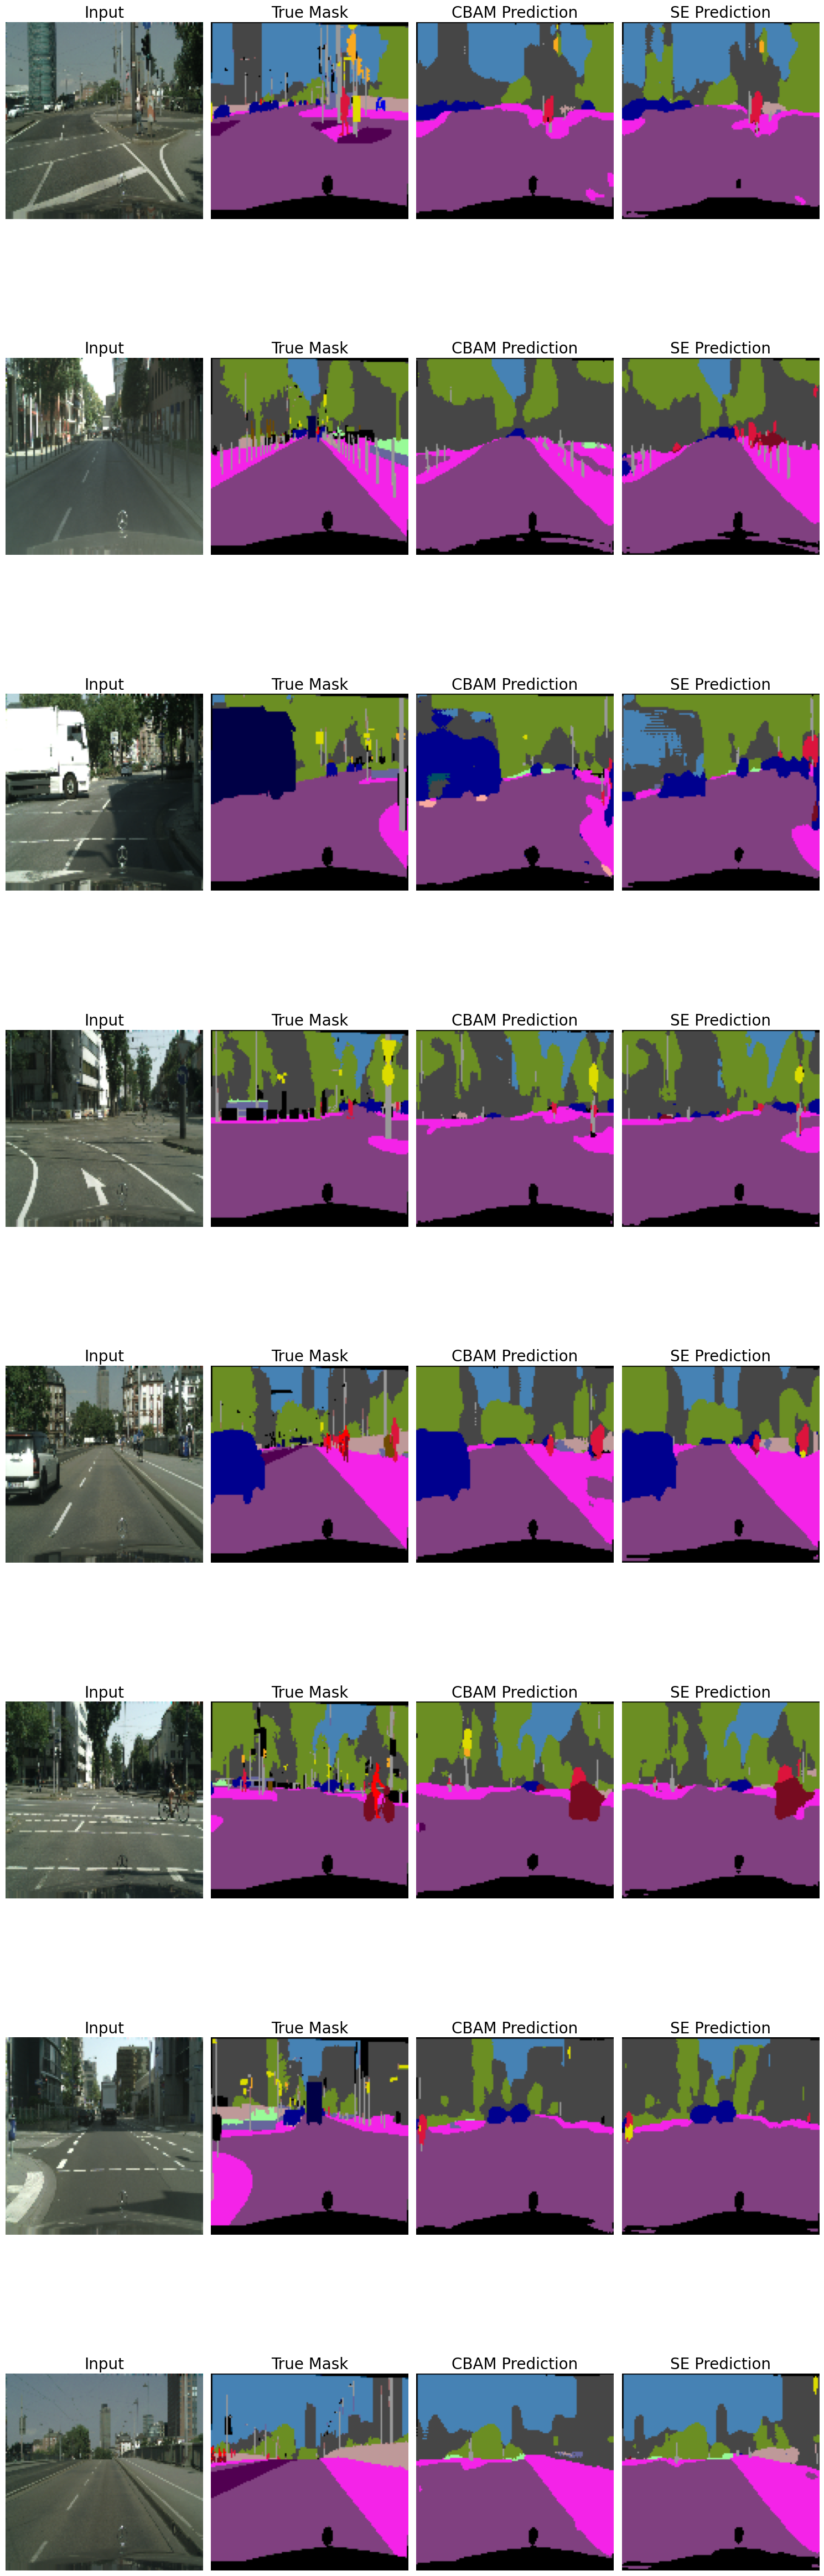

In [25]:
SE_prediction = SE_unet.predict(inp)
CBAM_prediction = cbam_unet.predict(inp)
true_masks = np.argmax(out, axis = -1)
SE_mask = np.argmax(SE_prediction, axis = -1)
CBAM_mask = np.argmax(CBAM_prediction, axis = -1)

fig, axes = plt.subplots(8, 4, figsize=(15, 50))

for index, (input, true_mask, CBAM_prediction, SE_prediction ) in enumerate(zip(inp, true_masks, CBAM_mask, SE_mask)):

    axes[index, 0].imshow( input)
    axes[index,0].set_title("Input", fontsize=20)
    axes[index, 0].axis('off')

    # Display the true mask
    temp = np.zeros([true_mask.shape[0], true_mask.shape[1], 3], dtype='uint8')
    for row in range(true_mask.shape[0]):
        for col in range(true_mask.shape[1]):
            temp[row, col, :] = id_to_color[true_mask[row, col]]

    axes[index, 1].imshow(temp)
    axes[index,1].set_title("True Mask", fontsize=20)
    axes[index, 1].axis('off')
    # Display the corresponding prediction
    temp = np.zeros([CBAM_prediction.shape[0], CBAM_prediction.shape[1], 3], dtype='uint8')
    for row in range(CBAM_prediction.shape[0]):
        for col in range(CBAM_prediction.shape[1]):
            temp[row, col, :] = id_to_color[CBAM_prediction[row, col]]

    axes[index, 2].imshow(temp)
    axes[index, 2].set_title("CBAM Prediction", fontsize = 20)
    axes[index, 2].axis('off')

    temp = np.zeros([SE_prediction.shape[0], SE_prediction.shape[0], 3], dtype='uint8')
    for row in range(SE_prediction.shape[0]):
        for col in range(SE_prediction.shape[0]):
            temp[row, col, :] = id_to_color[SE_prediction[row, col]]

    axes[index, 3].imshow(temp)
    axes[index, 3].set_title("SE Prediction", fontsize=20)
    axes[index, 3].axis('off')

plt.tight_layout()
plt.show()

In [26]:
cbam_unet.evaluate(test_gen)

62/62 [==============================] - 48s 719ms/step - loss: 0.2269 - accuracy: 0.8170 - dice_coef_multilabel: 0.4527


[0.22694209218025208, 0.8169524669647217, 0.452717661857605]

In [28]:
SE_unet.evaluate(test_gen)

62/62 [==============================] - 44s 699ms/step - loss: 0.2326 - accuracy: 0.8115 - dice_coef_multilabel: 0.4562


[0.2325560748577118, 0.8115212321281433, 0.45622673630714417]